In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-19 18:56:16.926945: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 18:56:16.956155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 18:56:17.413059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados 

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_TOTAL_MOLLUSCS = pd.DataFrame(df[['Ano','TOTAL_MOLLUSCS']])

dados = df_TOTAL_MOLLUSCS.dropna()
anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

pesca = dados['TOTAL_MOLLUSCS'].values

In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

pesca_mean = np.mean(pesca)
pesca_std = np.std(pesca)
pesca_norm = (pesca - pesca_mean)/pesca_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,pesca_norm, epochs=800, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/pesos pesca total/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
#Pegando os pesos salvos
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/pesos pesca total/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[34.274323]
 [40.03427 ]
 [45.418457]
 [45.975098]
 [41.93802 ]
 [36.598267]]


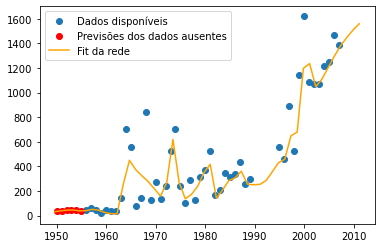

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*pesca_std + pesca_mean
prev_ausentes = model.predict(anos_para_prever_norm)*pesca_std + pesca_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,pesca,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*pesca_std + pesca_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

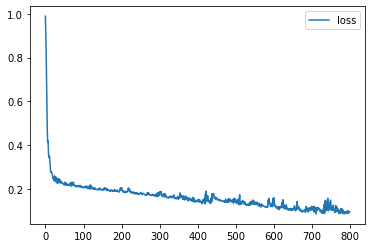

In [70]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [7]:
#Planilha com os dados preenchidos

df_previsoes = pd.DataFrame({'Ano':anos_para_prever, 'TOTAL_MOLLUSCS':prev_ausentes.flatten()})

df_preenchido = pd.concat((dados,df_previsoes)).sort_values('Ano')


with pd.option_context('display.max_rows', None,):
    print(df_preenchido)

df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Previsão TOTAL_MOLLUSCS.xlsx')

     Ano  TOTAL_MOLLUSCS
0   1950       34.274323
1   1951       40.034271
2   1952       45.418457
3   1953       45.975098
4   1954       41.938019
5   1955       36.598267
6   1956       43.670000
7   1957       64.000000
8   1958       44.000000
9   1959       23.000000
10  1960       43.000000
11  1961       36.000000
12  1962       38.000000
13  1963      141.000000
14  1964      708.000000
15  1965      560.000000
16  1966       75.000000
17  1967      145.000000
18  1968      843.000000
19  1969      125.000000
20  1970      277.000000
21  1971      133.000000
22  1972      241.000000
23  1973      526.000000
24  1974      704.000000
25  1975      238.000000
26  1976      103.000000
27  1977      292.000000
28  1978      131.000000
29  1979      314.000000
30  1980      368.000000
31  1981      527.000000
32  1982      171.000000
33  1983      206.000000
34  1984      344.000000
35  1985      313.000000
36  1986      339.000000
37  1987      436.000000
38  1988      260.000000
